In [6]:
!nvidia-smi

Mon Oct 12 20:42:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 419.71       Driver Version: 419.71       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8     2W /  N/A |    132MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
!pip install gdown
!pip install tensorflow-gpu

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupKFold
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
#Labels each column for the pandas datafram
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

#Generate datafram (df) by reading the input .csv file
df = pd.read_csv('gesture_data.csv', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'') #Gets rid of semicolon at the end of the 
df['z_axis'] = df.z_axis.astype(np.float64) #Convert z-axis values to float
df.dropna(axis=0, how='any', inplace=True) #Gets rid of blank lines

df['user_id'] = df.user_id.astype(int) #Convert the user id variable to int

C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
#Check that the dataframe has been generated
print(df.head())
print("Shape", df.shape)

   user_id activity     timestamp    x_axis    y_axis    z_axis
0       30   waving  4.582675e+09 -0.353728  5.283476  7.901423
1       30   waving  4.588676e+09 -0.277715  5.296046  8.208766
2       30   waving  4.594678e+09 -0.277715  5.296046  8.208766
3       30   waving  4.607681e+09 -0.238512  5.258937  8.365580
4       30   waving  4.614681e+09 -0.201104  5.226916  8.395206
Shape (131205, 6)


In [11]:
class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):

        if logs.get('accuracy') >= 1.0:

            self.model.stop_training = True

In [12]:
def compile_model(X_train, X_val, y_train, y_val,units=128,dropout_rate=0.5):
    model = keras.Sequential()
    model.add(
        keras.layers.Bidirectional(
          keras.layers.LSTM(
              units=units, 
              input_shape=[X_train.shape[1], X_train.shape[2]]
          )
        )
    )
    model.add(keras.layers.Dropout(rate=dropout_rate))
    model.add(keras.layers.Dense(units=units, activation='tanh'))
    model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
    callback = CustomCallback()
    model.compile(optimizer=Adam(learning_rate = 0.001,decay = 1e-6), loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[callback]
     
    )
    return model, history
    

In [13]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [14]:
def create_dataset_with_userid(X, y,subjects, time_steps=1, step=1):
    Xs, ys, us = [], [],[]
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        user_id = subjects.iloc[i: i + time_steps]
        Xs.append(v)
        us.append(stats.mode(user_id)[0][0])
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1),np.array(us).reshape(-1, 1)

In [15]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [110]:
!rm -rf ./logs/ 

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [115]:
TIME_STEPS=200
Steps =40
X_train, y_train, groups_user = create_dataset_with_userid(
        df[['x_axis', 'y_axis', 'z_axis']], 
        df.activity, 
        df.user_id,
        TIME_STEPS,
        Steps
        
)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)

In [116]:
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size = 0.2, random_state = 0,  stratify = y_train)

In [117]:
y_val.shape

(656, 11)

In [123]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32,64,128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2,0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs2/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [128]:
def train_test_model(hparams):
    model = keras.Sequential()
    model.add(
        keras.layers.Bidirectional(
          keras.layers.LSTM(
              units=hparams[HP_NUM_UNITS], 
              input_shape=[X_train.shape[1], X_train.shape[2]]
          )
        )
    )
    model.add(keras.layers.Dropout(hparams[HP_DROPOUT]))
    model.add(keras.layers.Dense(units=hparams[HP_NUM_UNITS], activation='tanh'))
    model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer=hparams[HP_OPTIMIZER], loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

    model.fit(X_train, y_train, epochs=30) # Run with 1 epoch to speed things up for demo purposes
    _, accuracy = model.evaluate(X_val, y_val)
    return accuracy

In [134]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [4]:
logdir = "logs2/hparam_tuning/"

In [136]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
#       print(train_test_model(hparams))
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      a = run('logs2/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 32, 'dropout': 0.2, 'optimizer': 'adam'}
Epoch 1/30
82/82 [==============================] - 3s 36ms/step - loss: 1.9097 - accuracy: 0.3786
Epoch 2/30
82/82 [==============================] - 3s 36ms/step - loss: 1.0180 - accuracy: 0.7168
Epoch 3/30
82/82 [==============================] - 3s 37ms/step - loss: 0.5461 - accuracy: 0.8573
Epoch 4/30
82/82 [==============================] - 3s 37ms/step - loss: 0.3807 - accuracy: 0.9122
Epoch 5/30
82/82 [==============================] - 3s 39ms/step - loss: 0.2637 - accuracy: 0.9450
Epoch 6/30
82/82 [==============================] - 3s 37ms/step - loss: 0.1653 - accuracy: 0.9691
Epoch 7/30
82/82 [==============================] - 3s 38ms/step - loss: 0.1582 - accuracy: 0.9656
Epoch 8/30
82/82 [==============================] - 3s 38ms/step - loss: 0.1041 - accuracy: 0.9779
Epoch 9/30
82/82 [==============================] - 3s 38ms/step - loss: 0.0933 - accuracy: 0.9794
Epoch 10/30
82/82 [=========

'kill' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
%tensorboard --logdir logs2/hparam_tuning --port=8008

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 13904.

In [16]:
from sklearn.model_selection import LeaveOneGroupOut
TIME_STEPS=200
Steps =40
X_train, y_train, groups_user = create_dataset_with_userid(
        df[['x_axis', 'y_axis', 'z_axis']], 
        df.activity, 
        df.user_id,
        TIME_STEPS,
        Steps
        
)

In [17]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)

In [18]:
enc.categories_[0]

array(['circle', 'dab', 'drinking', 'lineH', 'lineV', 'outwardsL',
       'outwardsR', 'semicircle', 'towards', 'waving', 'xmark'],
      dtype='<U10')

In [148]:
pip install -U scikit-learn

  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\tt0342\\appdata\\local\\continuum\\anaconda3\\lib\\site-packages\\~klearn\\metrics\\cluster\\expected_mutual_info_fast.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [19]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(y_true,y_pred,class_names,c):
    total = 0
    cm = confusion_matrix(y_true, y_pred, class_names )
    total += cm
    total = total/11
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax = sns.heatmap(
          cm, 
          annot=True, 
          fmt="d", 
          ax=ax
      )

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(class_names, rotation = 45)
    ax.set_yticklabels(class_names, rotation=0)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.savefig("Confusion_matrix_cv_"+str(c)+".png")
    plt.show() # ta-da!

Epoch 1/20
35/35 [==============================] - 15s 434ms/step - loss: 1.4950 - accuracy: 0.4901 - val_loss: 0.8965 - val_accuracy: 0.6964
Epoch 2/20
35/35 [==============================] - 15s 421ms/step - loss: 0.7990 - accuracy: 0.7009 - val_loss: 0.4213 - val_accuracy: 0.8543
Epoch 3/20
35/35 [==============================] - 15s 428ms/step - loss: 0.3786 - accuracy: 0.8775 - val_loss: 0.2641 - val_accuracy: 0.9271
Epoch 4/20
35/35 [==============================] - 15s 433ms/step - loss: 0.2659 - accuracy: 0.9180 - val_loss: 0.3942 - val_accuracy: 0.8381
Epoch 5/20
35/35 [==============================] - 15s 433ms/step - loss: 0.2214 - accuracy: 0.9293 - val_loss: 0.1416 - val_accuracy: 0.9312
Epoch 6/20
35/35 [==============================] - 15s 435ms/step - loss: 0.1206 - accuracy: 0.9676 - val_loss: 0.0494 - val_accuracy: 0.9838
Epoch 7/20
35/35 [==============================] - 15s 435ms/step - loss: 0.0408 - accuracy: 0.9919 - val_loss: 0.0330 - val_accuracy: 0.9919

C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['circle' 'dab' 'drinking' 'lineH' 'lineV' 'outwardsL' 'outwardsR'
 'semicircle' 'towards' 'waving' 'xmark'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['circle' 'dab' 'drinking' 'lineH' 'lineV' 'outwardsL' 'outwardsR'
 'semicircle' 'towards' 'waving' 'xmark'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

      circle       1.00      0.73      0.85        49
         dab       0.96      0.96      0.96        57
    drinking       1.00      1.00      1.00        41
       lineH       0.95      0.98      0.96        55
       lineV       1.00      0.79      0.88        57
   outwardsL       0.77      1.00      0.87        66
   outwardsR       0.89      0.93      0.91        61
  semicircle       0.95      0.86      0.90       100
     towards       0.96      1.00      0.98        43
      waving       0.99      1.00      0.99       230
       xmark       0.89      1.00      0.94        50

    accuracy                           0.94       809
   macro avg       0.94      0.93      0.93       809
weighted avg       0.95      0.94      0.94       809



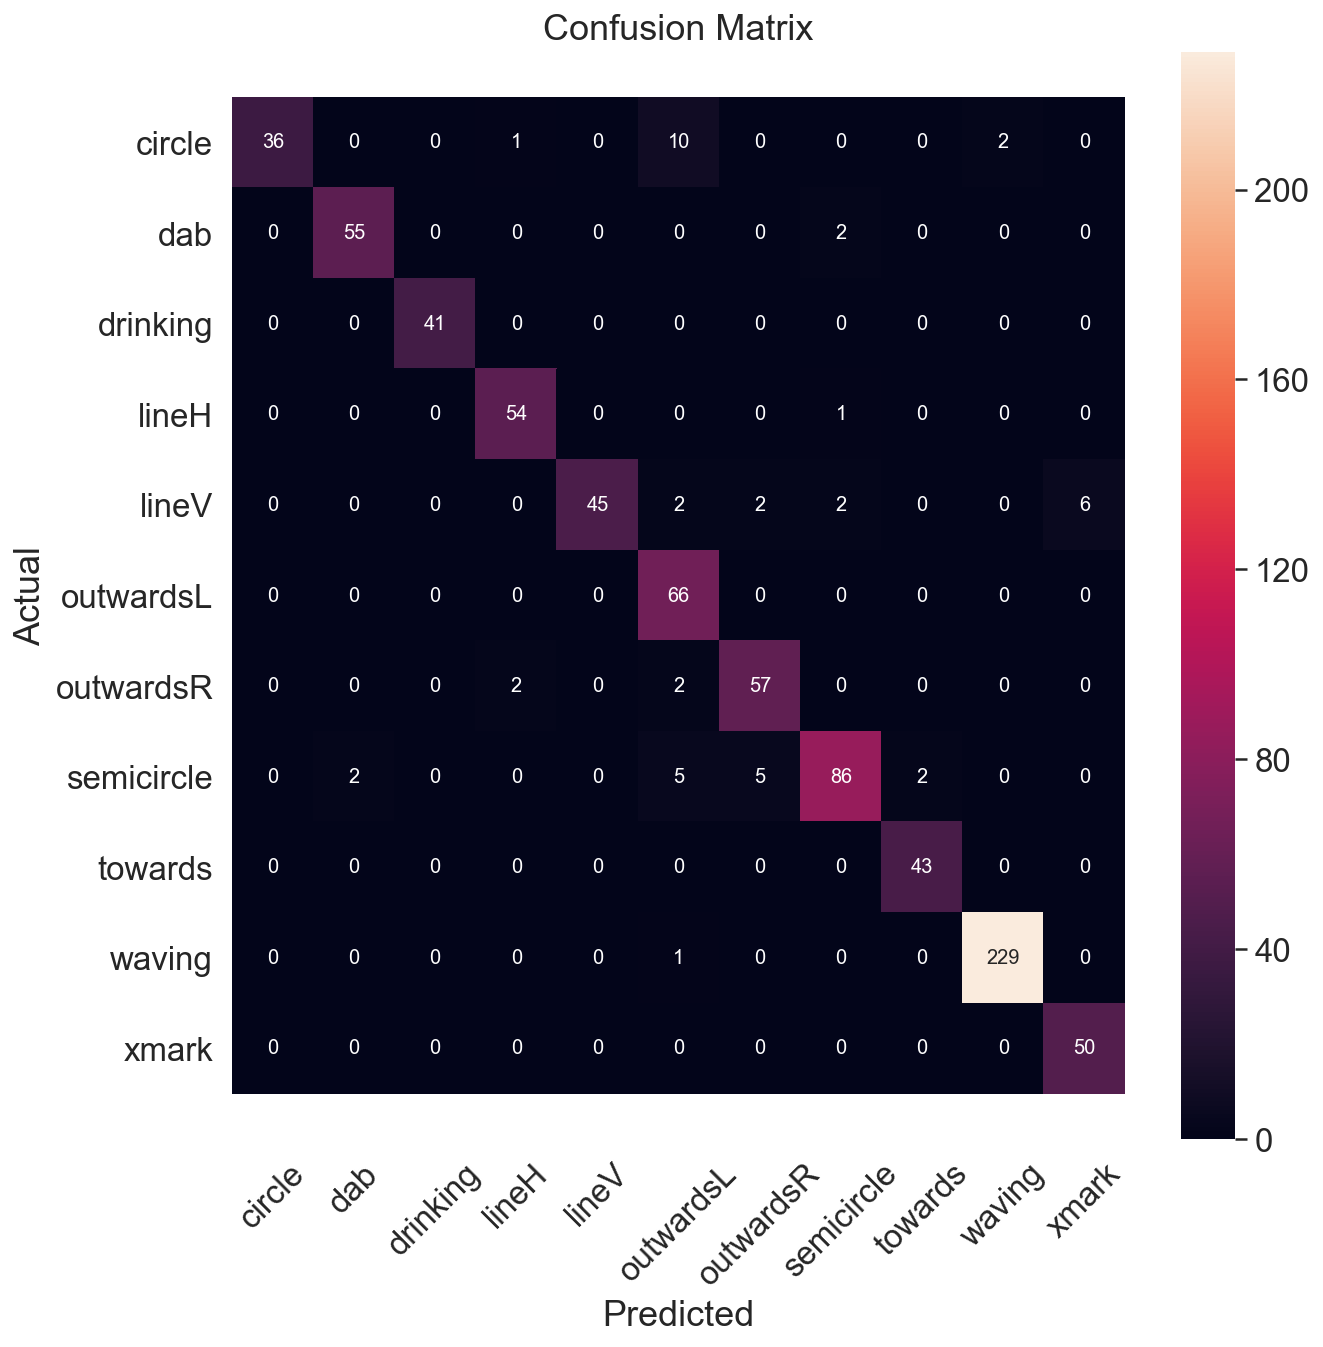

Epoch 1/20
38/38 [==============================] - 18s 474ms/step - loss: 1.3490 - accuracy: 0.5375 - val_loss: 0.8238 - val_accuracy: 0.7074
Epoch 2/20
38/38 [==============================] - 17s 442ms/step - loss: 0.6066 - accuracy: 0.7941 - val_loss: 0.5437 - val_accuracy: 0.8296
Epoch 3/20
38/38 [==============================] - 17s 447ms/step - loss: 0.3320 - accuracy: 0.8954 - val_loss: 0.2023 - val_accuracy: 0.9259
Epoch 4/20
38/38 [==============================] - 17s 440ms/step - loss: 0.1527 - accuracy: 0.9613 - val_loss: 0.1371 - val_accuracy: 0.9519
Epoch 5/20
38/38 [==============================] - 19s 491ms/step - loss: 0.0881 - accuracy: 0.9753 - val_loss: 0.0534 - val_accuracy: 0.9815
Epoch 6/20
38/38 [==============================] - 19s 488ms/step - loss: 0.0544 - accuracy: 0.9868 - val_loss: 0.0820 - val_accuracy: 0.9741
Epoch 7/20
38/38 [==============================] - 19s 487ms/step - loss: 0.0515 - accuracy: 0.9868 - val_loss: 0.0516 - val_accuracy: 0.9815

C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['circle' 'dab' 'drinking' 'lineH' 'lineV' 'outwardsL' 'outwardsR'
 'semicircle' 'towards' 'waving' 'xmark'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['circle' 'dab' 'drinking' 'lineH' 'lineV' 'outwardsL' 'outwardsR'
 'semicircle' 'towards' 'waving' 'xmark'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

      circle       0.97      1.00      0.99        34
         dab       1.00      1.00      1.00        35
    drinking       1.00      1.00      1.00        40
       lineH       1.00      1.00      1.00        53
       lineV       0.98      1.00      0.99        58
   outwardsL       1.00      1.00      1.00        50
   outwardsR       1.00      1.00      1.00        51
  semicircle       1.00      1.00      1.00        95
     towards       1.00      1.00      1.00        43
      waving       1.00      0.98      0.99        62
       xmark       1.00      0.98      0.99        57

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



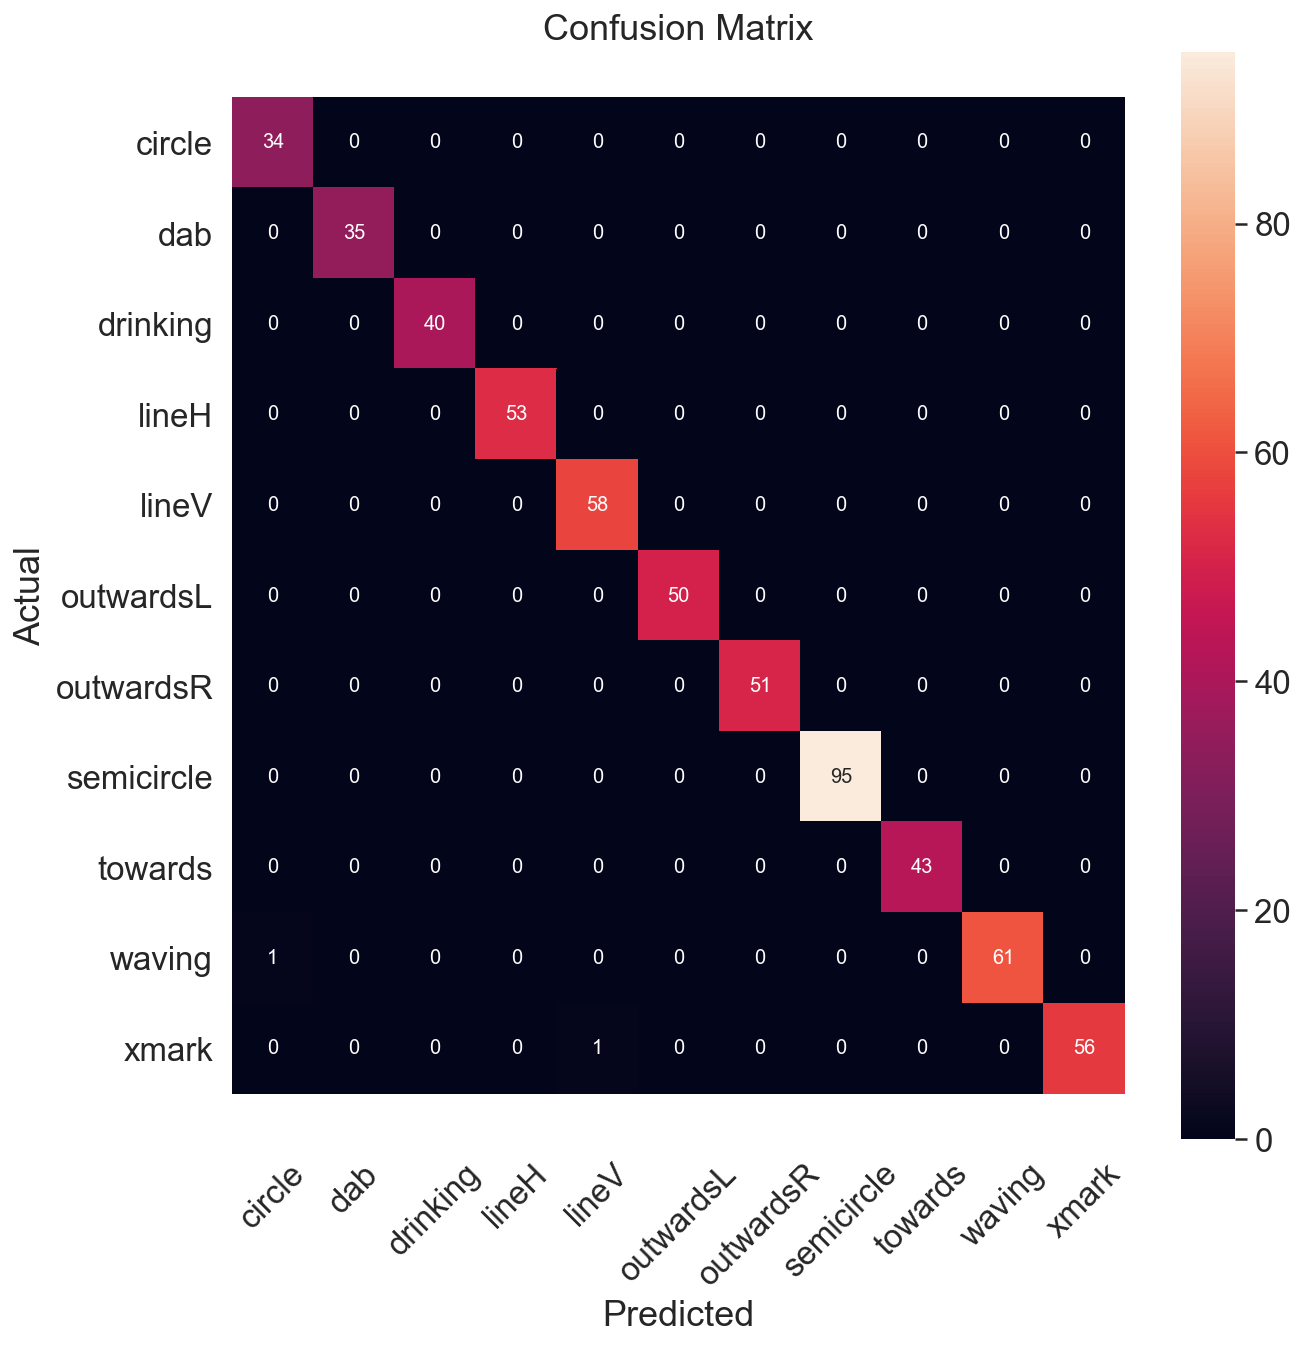

Epoch 1/20
38/38 [==============================] - 18s 469ms/step - loss: 1.4049 - accuracy: 0.5130 - val_loss: 0.7482 - val_accuracy: 0.7815
Epoch 2/20
38/38 [==============================] - 17s 460ms/step - loss: 0.7625 - accuracy: 0.7324 - val_loss: 0.4673 - val_accuracy: 0.8667
Epoch 3/20
38/38 [==============================] - 19s 503ms/step - loss: 0.4136 - accuracy: 0.8596 - val_loss: 0.2652 - val_accuracy: 0.9037
Epoch 4/20
38/38 [==============================] - 20s 520ms/step - loss: 0.3861 - accuracy: 0.8802 - val_loss: 0.2337 - val_accuracy: 0.9407
Epoch 5/20
38/38 [==============================] - 20s 531ms/step - loss: 0.2394 - accuracy: 0.9292 - val_loss: 0.0795 - val_accuracy: 0.9889
Epoch 6/20
38/38 [==============================] - 18s 481ms/step - loss: 0.1505 - accuracy: 0.9634 - val_loss: 0.0998 - val_accuracy: 0.9852
Epoch 7/20
38/38 [==============================] - 18s 467ms/step - loss: 0.0942 - accuracy: 0.9790 - val_loss: 0.0285 - val_accuracy: 0.9926

C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['circle' 'dab' 'drinking' 'lineH' 'lineV' 'outwardsL' 'outwardsR'
 'semicircle' 'towards' 'waving' 'xmark'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['circle' 'dab' 'drinking' 'lineH' 'lineV' 'outwardsL' 'outwardsR'
 'semicircle' 'towards' 'waving' 'xmark'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

      circle       0.92      0.95      0.94        38
         dab       1.00      0.93      0.96        44
    drinking       1.00      0.86      0.93        44
       lineH       1.00      1.00      1.00        48
       lineV       0.88      1.00      0.94        37
   outwardsL       0.53      1.00      0.69        47
   outwardsR       0.94      1.00      0.97        49
  semicircle       0.92      0.98      0.95        50
     towards       1.00      0.42      0.60        73
      waving       1.00      0.97      0.98        99
       xmark       1.00      1.00      1.00        48

    accuracy                           0.90       577
   macro avg       0.93      0.92      0.91       577
weighted avg       0.94      0.90      0.90       577



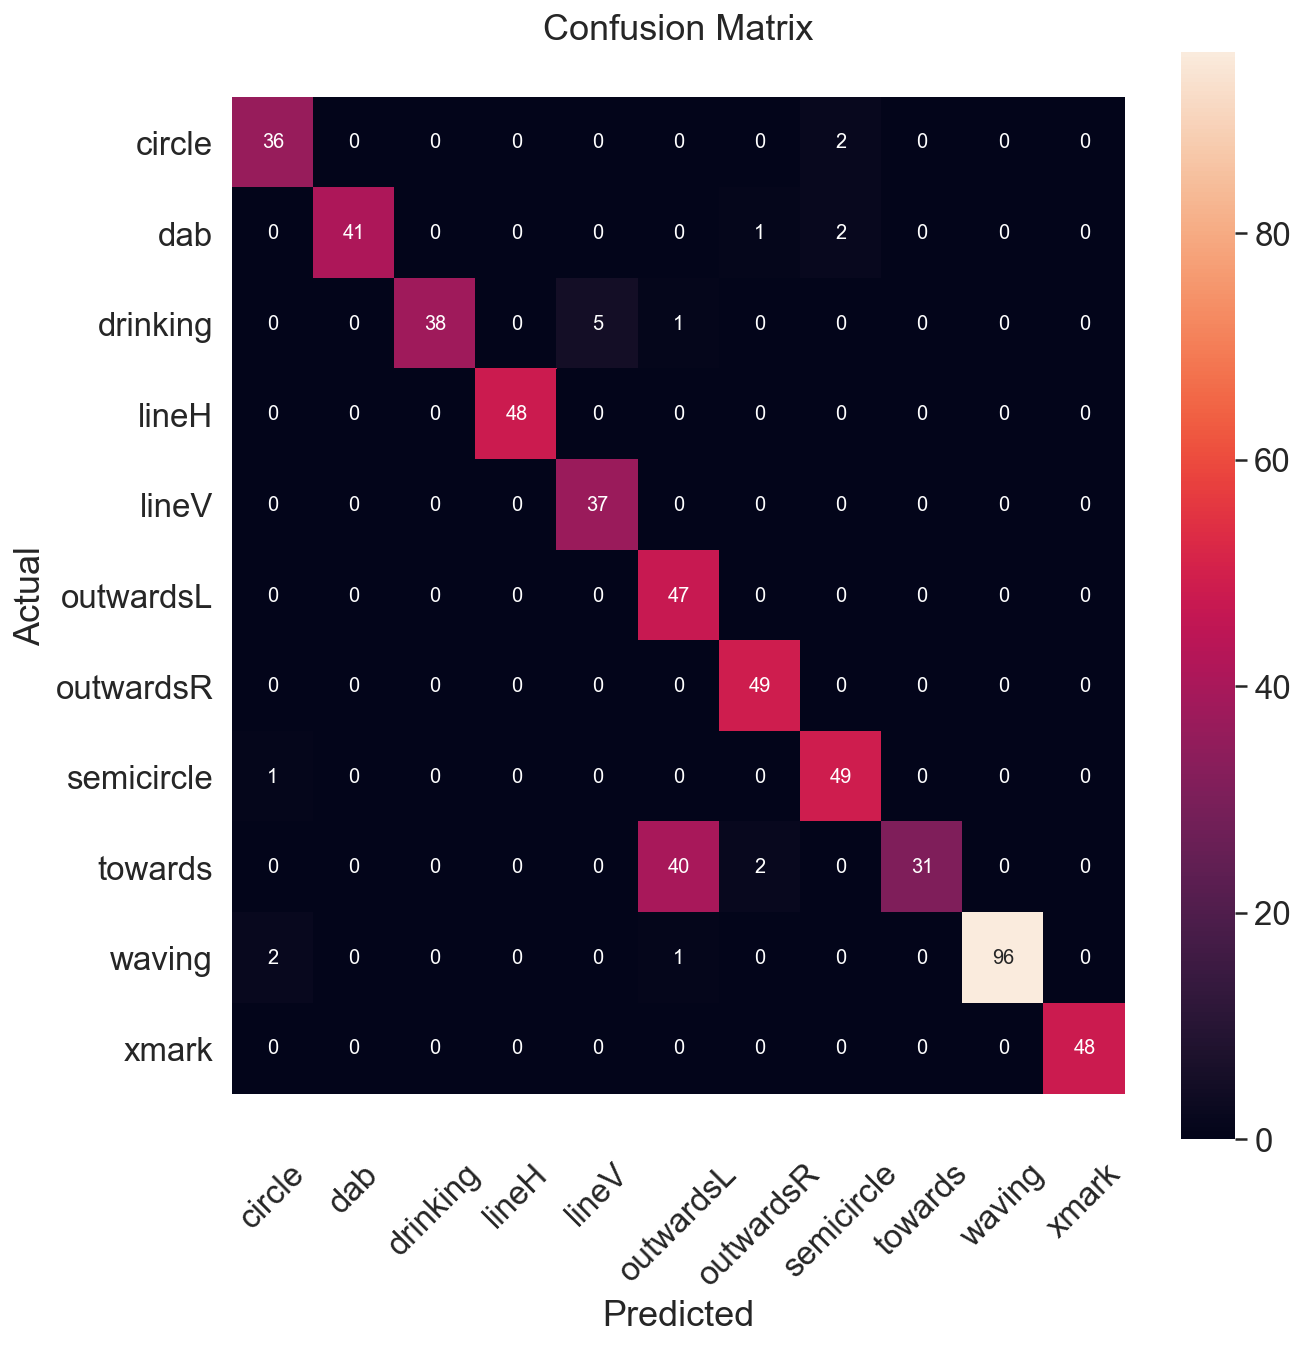

Epoch 1/20
39/39 [==============================] - 20s 518ms/step - loss: 1.3490 - accuracy: 0.5341 - val_loss: 0.9181 - val_accuracy: 0.6245
Epoch 2/20
39/39 [==============================] - 19s 476ms/step - loss: 0.6124 - accuracy: 0.7771 - val_loss: 0.4929 - val_accuracy: 0.7870
Epoch 3/20
39/39 [==============================] - 19s 485ms/step - loss: 0.3897 - accuracy: 0.8779 - val_loss: 0.1881 - val_accuracy: 0.9386
Epoch 4/20
39/39 [==============================] - 20s 503ms/step - loss: 0.1642 - accuracy: 0.9522 - val_loss: 0.0668 - val_accuracy: 0.9856
Epoch 5/20
39/39 [==============================] - 19s 483ms/step - loss: 0.0979 - accuracy: 0.9723 - val_loss: 0.0661 - val_accuracy: 0.9711
Epoch 6/20
39/39 [==============================] - 19s 483ms/step - loss: 0.0787 - accuracy: 0.9791 - val_loss: 0.0649 - val_accuracy: 0.9819
Epoch 7/20
39/39 [==============================] - 19s 492ms/step - loss: 0.0456 - accuracy: 0.9924 - val_loss: 0.0239 - val_accuracy: 0.9928

C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['circle' 'dab' 'drinking' 'lineH' 'lineV' 'outwardsL' 'outwardsR'
 'semicircle' 'towards' 'waving' 'xmark'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['circle' 'dab' 'drinking' 'lineH' 'lineV' 'outwardsL' 'outwardsR'
 'semicircle' 'towards' 'waving' 'xmark'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

      circle       1.00      1.00      1.00        50
         dab       1.00      0.97      0.99        40
    drinking       1.00      1.00      1.00        47
       lineH       1.00      1.00      1.00        45
       lineV       0.98      1.00      0.99        56
   outwardsL       1.00      1.00      1.00        39
   outwardsR       1.00      1.00      1.00        44
  semicircle       1.00      0.97      0.99        39
     towards       1.00      1.00      1.00        44
      waving       0.98      1.00      0.99        58
       xmark       1.00      1.00      1.00        47

    accuracy                           1.00       509
   macro avg       1.00      1.00      1.00       509
weighted avg       1.00      1.00      1.00       509



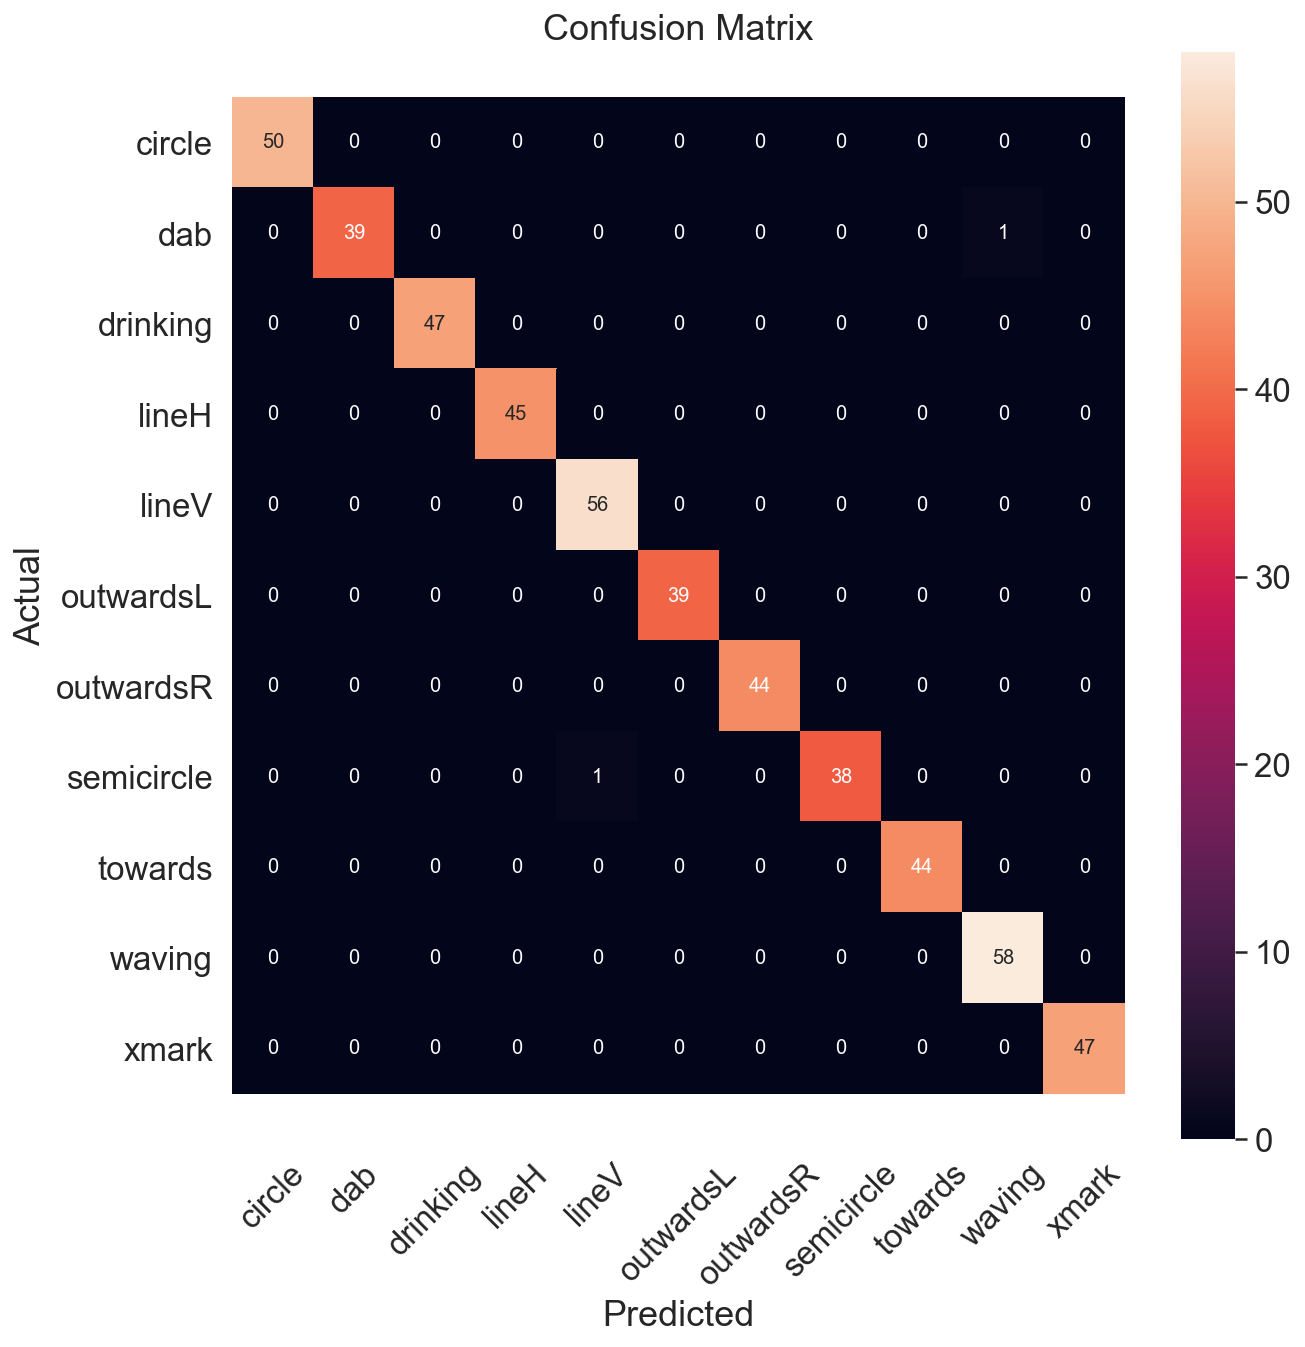

Epoch 1/20
40/40 [==============================] - 18s 458ms/step - loss: 1.3899 - accuracy: 0.5269 - val_loss: 0.8472 - val_accuracy: 0.7046
Epoch 2/20
40/40 [==============================] - 19s 480ms/step - loss: 0.5293 - accuracy: 0.8282 - val_loss: 0.3886 - val_accuracy: 0.8683
Epoch 3/20
40/40 [==============================] - 18s 447ms/step - loss: 0.4590 - accuracy: 0.8472 - val_loss: 0.3180 - val_accuracy: 0.8861
Epoch 4/20
40/40 [==============================] - 18s 447ms/step - loss: 0.2079 - accuracy: 0.9394 - val_loss: 0.1534 - val_accuracy: 0.9537
Epoch 5/20
40/40 [==============================] - 18s 445ms/step - loss: 0.1907 - accuracy: 0.9351 - val_loss: 0.1695 - val_accuracy: 0.9253
Epoch 6/20
40/40 [==============================] - 18s 443ms/step - loss: 0.1819 - accuracy: 0.9426 - val_loss: 0.4890 - val_accuracy: 0.8256
Epoch 7/20
40/40 [==============================] - 17s 437ms/step - loss: 0.2021 - accuracy: 0.9390 - val_loss: 0.1306 - val_accuracy: 0.9644

C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['circle' 'dab' 'drinking' 'lineH' 'lineV' 'outwardsL' 'outwardsR'
 'semicircle' 'towards' 'waving' 'xmark'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['circle' 'dab' 'drinking' 'lineH' 'lineV' 'outwardsL' 'outwardsR'
 'semicircle' 'towards' 'waving' 'xmark'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

      circle       1.00      1.00      1.00        37
         dab       1.00      1.00      1.00        44
    drinking       1.00      1.00      1.00        31
       lineH       1.00      1.00      1.00        51
       lineV       1.00      1.00      1.00        77
   outwardsL       1.00      1.00      1.00        42
   outwardsR       0.76      1.00      0.86        28
  semicircle       1.00      1.00      1.00        23
     towards       1.00      0.86      0.93        73
      waving       0.93      1.00      0.97        14
       xmark       1.00      1.00      1.00        49

    accuracy                           0.98       469
   macro avg       0.97      0.99      0.98       469
weighted avg       0.98      0.98      0.98       469



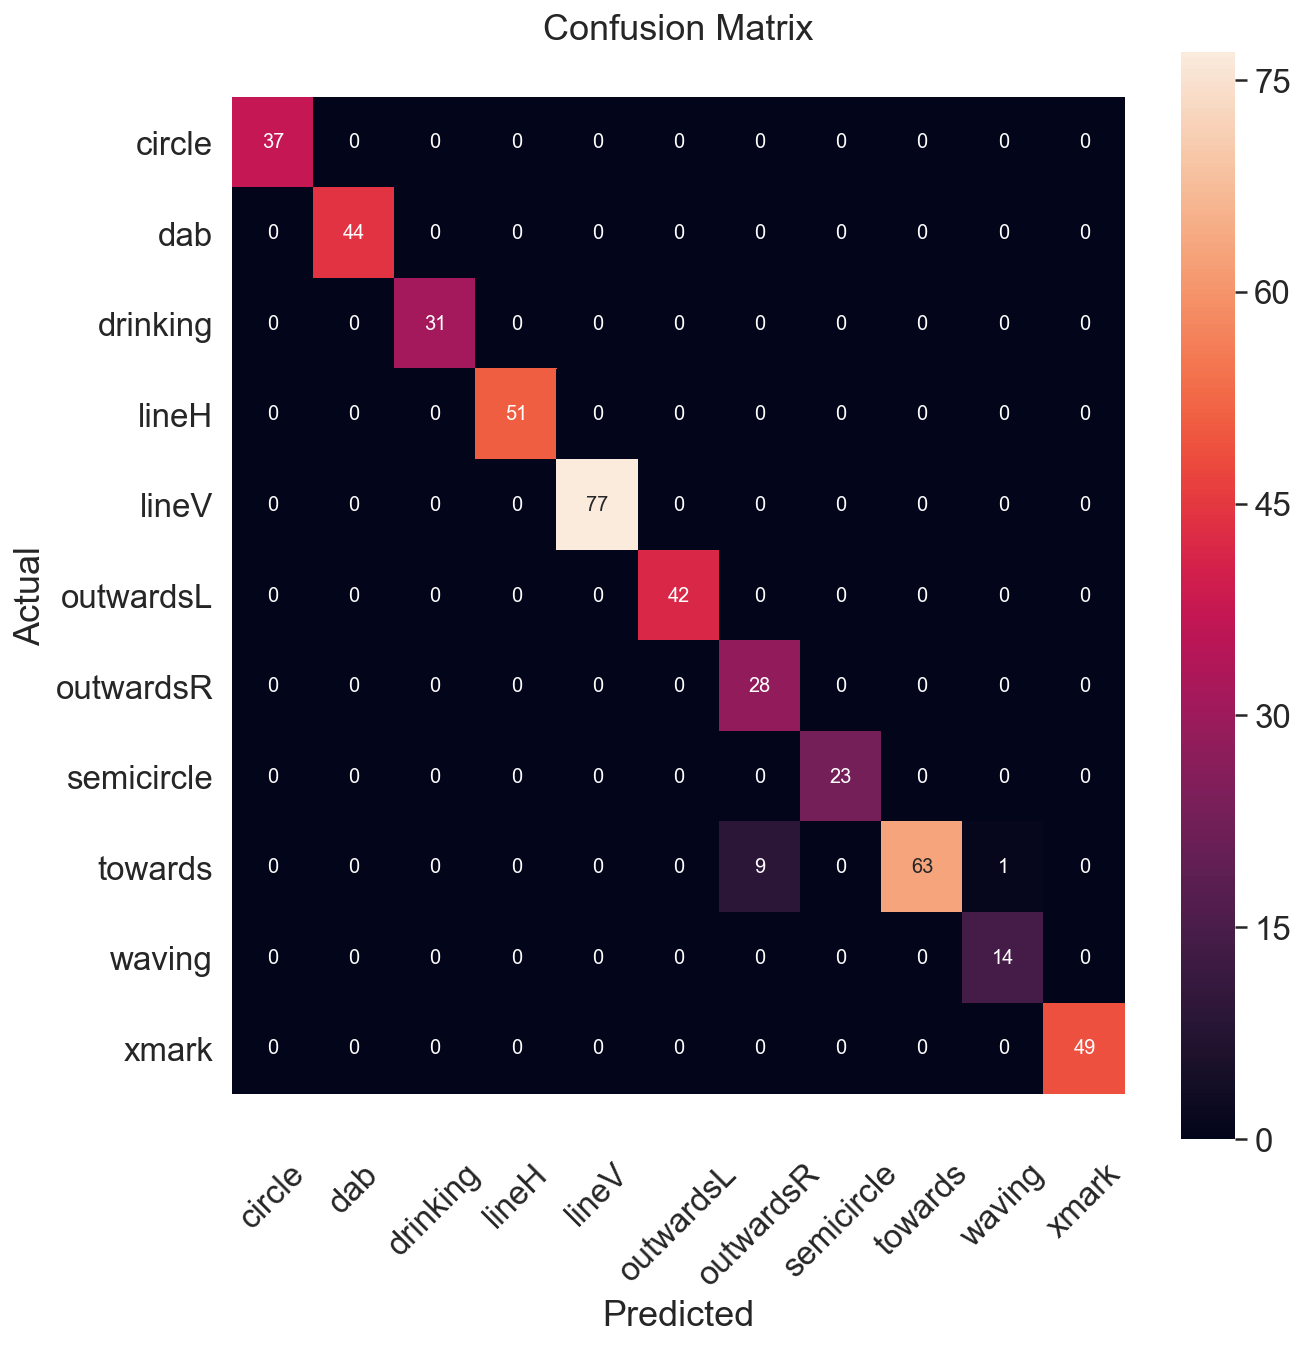

Epoch 1/20
42/42 [==============================] - 21s 489ms/step - loss: 1.3087 - accuracy: 0.5686 - val_loss: 0.6489 - val_accuracy: 0.7966
Epoch 2/20
42/42 [==============================] - 20s 481ms/step - loss: 0.4744 - accuracy: 0.8530 - val_loss: 0.2640 - val_accuracy: 0.9119
Epoch 3/20
42/42 [==============================] - 20s 474ms/step - loss: 0.2881 - accuracy: 0.9105 - val_loss: 0.2313 - val_accuracy: 0.9186
Epoch 4/20
42/42 [==============================] - 20s 482ms/step - loss: 0.1891 - accuracy: 0.9494 - val_loss: 0.0923 - val_accuracy: 0.9797
Epoch 5/20
42/42 [==============================] - 20s 487ms/step - loss: 0.1655 - accuracy: 0.9509 - val_loss: 0.0899 - val_accuracy: 0.9763
Epoch 6/20
42/42 [==============================] - 20s 486ms/step - loss: 0.0502 - accuracy: 0.9898 - val_loss: 0.0431 - val_accuracy: 0.9932
Epoch 7/20
42/42 [==============================] - 20s 486ms/step - loss: 0.0675 - accuracy: 0.9781 - val_loss: 0.0538 - val_accuracy: 0.9898

C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['circle' 'dab' 'drinking' 'lineH' 'lineV' 'outwardsL' 'outwardsR'
 'semicircle' 'towards' 'waving' 'xmark'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tt0342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

              precision    recall  f1-score   support

      circle       1.00      0.99      0.99        94
         dab       0.00      0.00      0.00         0
    drinking       0.00      0.00      0.00         0
       lineH       1.00      0.94      0.97        33
       lineV       0.00      0.00      0.00         0
   outwardsL       1.00      1.00      1.00        56
   outwardsR       0.94      1.00      0.97        34
  semicircle       0.94      0.89      0.91        18
     towards       0.00      0.00      0.00         0
      waving       1.00      1.00      1.00        68
       xmark       1.00      1.00      1.00        31

   micro avg       0.99      0.99      0.99       334
   macro avg       0.63      0.62      0.62       334
weighted avg       0.99      0.99      0.99       334



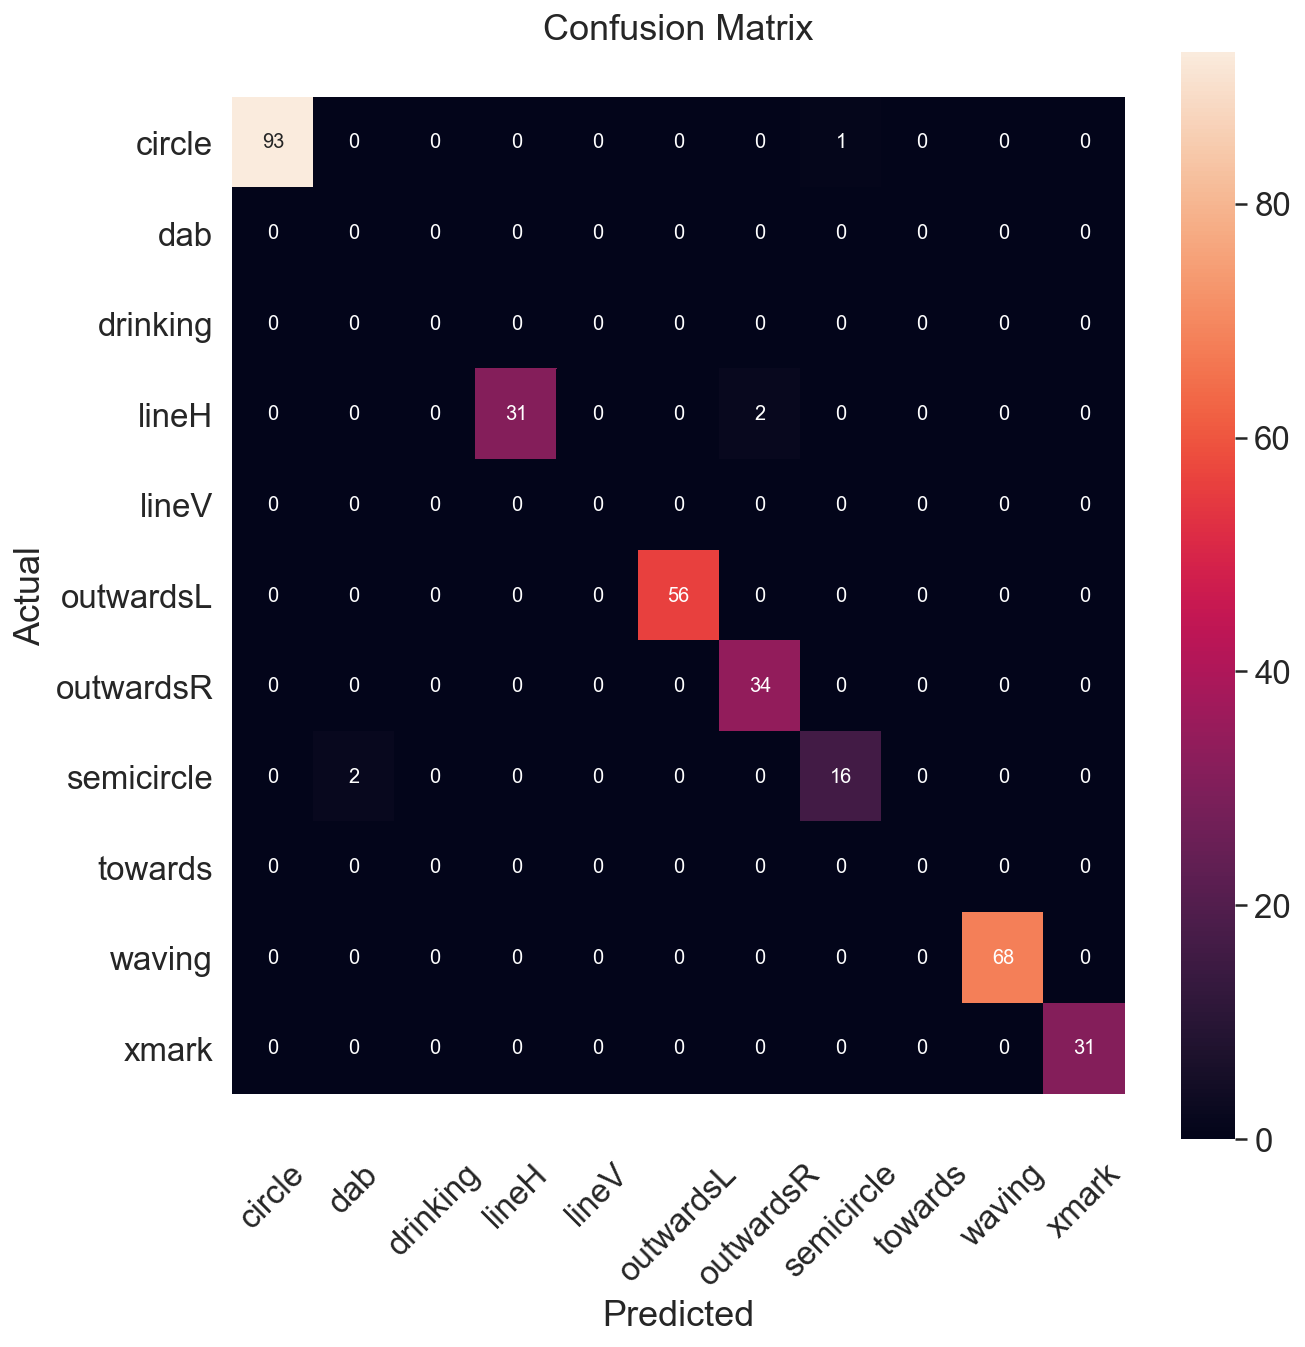

In [23]:
pred = list()
classifications = list()
e1 =list()
scores_list = list()
units = 128
dropout_rate = 0.2
gkf = GroupKFold(n_splits=6)
c = 1
for train, test in gkf.split(X_train, y_train,groups_user):
    X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_train[train], y_train[train], test_size = 0.1, random_state = 0,  stratify = y_train[train])
#     print(X_train_c, X_val_c, y_train_c, y_val_c)
#     print("%s %s" % (X_train[train], y_train[test]))
    model, history = compile_model(X_train_c, X_val_c, y_train_c, y_val_c,units,dropout_rate)
    e= model.evaluate(X_train[test], y_train[test])
    e1.append(e)
    y_pred = model.predict(X_train[test])
    pred.append(y_pred)
    print(classification_report(enc.inverse_transform(y_train[test]), enc.inverse_transform(y_pred), enc.categories_[0]))
    draw_confusion_matrix(enc.inverse_transform(y_train[test]),enc.inverse_transform(y_pred),enc.categories_[0],c)
    c= c+1
    

In [24]:
e1

[[0.25349730253219604, 0.9419035911560059],
 [0.011588847264647484, 0.9965397715568542],
 [0.47985923290252686, 0.9012131690979004],
 [0.018545199185609818, 0.9960707426071167],
 [0.08367559313774109, 0.9786780476570129],
 [0.05527763441205025, 0.985029935836792]]

In [25]:
sum= 0
for index,acc in enumerate(e1):
    sum= sum+acc[1]
print("Avg Accuracy", (sum/6)*100)


Avg Accuracy 96.65725429852804


http://localhost:6006/

https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams